In [ ]:
import sys
print(sys.prefix)

In [ ]:
from DatabaseMergerCode.DatabaseMerger import OptunaStudyMerger

merger = OptunaStudyMerger(
    db_paths=[
        "Databases/optuna_study.db",
        "Databases/optuna_study_1.db",
        "Databases/optuna_study_2.db",
        "Databases/optuna_study_3.db",
        "Databases/optuna_study_4.db",
    ],
    merged_db_path="sqlite:///merged_optuna.db",
    merged_study_name="sindy_opt_merged",
    top_k=5
)

merger.merge_top_trials()
merger.print_top_trials()

In [1]:

from TrainingCode.ValidateTraining import TopTrialSelector, TrialEvaluator

# --- CONFIGURATION ---
DB_PATH = "merged_optuna.db"
STUDY_NAME = "sindy_opt_merged"
TOP_K = 5
TRIAL_INDEX_TO_RUN = 1  # <-- Change this (1 = best, 2 = second-best, etc.)


In [2]:
# --- STEP 1: Load and Save Top Trials ---
selector = TopTrialSelector(db_path=DB_PATH, study_name=STUDY_NAME, top_k=TOP_K)
selector.save_top_params("top_trial_params.pkl")

# --- STEP 2: Load Selected Trial Params ---
trial_params = selector.get_trial_params(TRIAL_INDEX_TO_RUN)


📂 Loading study: sindy_opt_merged from merged_optuna.db
✅ Loaded 5 top trials.
💾 Saved top-5 trial parameters to top_trial_params.pkl
🔍 Merged Parameters:
 dict_keys(['model', 'case', 'input_dim', 'latent_dim', 'poly_order', 'include_sine', 'fix_coefs', 'svd_dim', 'delay_embedded', 'scale', 'coefficient_initialization', 'coefficient_initialization_constant', 'widths_ratios', 'max_epochs', 'patience', 'batch_size', 'learning_rate', 'lr_decay', 'loss_weight_rec', 'loss_weight_sindy_z', 'loss_weight_sindy_x', 'loss_weight_sindy_regularization', 'loss_weight_integral', 'loss_weight_x0', 'loss_weight_layer_l2', 'loss_weight_layer_l1', 'coefficient_threshold', 'threshold_frequency', 'print_frequency', 'sindy_pert', 'ode_net', 'ode_net_widths', 'exact_features', 'use_bias', 'tend', 'dt', 'train_ratio', 'data_path', 'save_checkpoints', 'save_freq', 'learning_rate_sched', 'use_sindycall', 'sparse_weighting', 'system_coefficients', 'update_freq', 'sindy_fixed_mask', 'sindy_fixed_values'])


In [3]:
# --- STEP 3: Run Training + Plot Evaluation ---
merged_params = selector.get_trial_params(TRIAL_INDEX_TO_RUN)
evaluator = TrialEvaluator(merged_params)
#import pprint
#pprint.pprint(merged_params)

🔍 Merged Parameters:
 dict_keys(['model', 'case', 'input_dim', 'latent_dim', 'poly_order', 'include_sine', 'fix_coefs', 'svd_dim', 'delay_embedded', 'scale', 'coefficient_initialization', 'coefficient_initialization_constant', 'widths_ratios', 'max_epochs', 'patience', 'batch_size', 'learning_rate', 'lr_decay', 'loss_weight_rec', 'loss_weight_sindy_z', 'loss_weight_sindy_x', 'loss_weight_sindy_regularization', 'loss_weight_integral', 'loss_weight_x0', 'loss_weight_layer_l2', 'loss_weight_layer_l1', 'coefficient_threshold', 'threshold_frequency', 'print_frequency', 'sindy_pert', 'ode_net', 'ode_net_widths', 'exact_features', 'use_bias', 'tend', 'dt', 'train_ratio', 'data_path', 'save_checkpoints', 'save_freq', 'learning_rate_sched', 'use_sindycall', 'sparse_weighting', 'system_coefficients', 'update_freq', 'sindy_fixed_mask', 'sindy_fixed_values'])
Generating Lorenz system...


In [4]:
import numpy as np
import math
np.math = math
# --- STEP 3: Run Training + Plot Evaluation ---
merged_params = selector.get_trial_params(TRIAL_INDEX_TO_RUN)

# Manually increase L1 regularization by a factor of 10
if "loss_weight_layer_l1" in merged_params:
    merged_params["loss_weight_layer_l1"] *= 10
else:
    merged_params["loss_weight_layer_l1"] = 1e-3  # or some reasonable fallback

evaluator = TrialEvaluator(merged_params)
evaluator.train_model()

🔍 Merged Parameters:
 dict_keys(['model', 'case', 'input_dim', 'latent_dim', 'poly_order', 'include_sine', 'fix_coefs', 'svd_dim', 'delay_embedded', 'scale', 'coefficient_initialization', 'coefficient_initialization_constant', 'widths_ratios', 'max_epochs', 'patience', 'batch_size', 'learning_rate', 'lr_decay', 'loss_weight_rec', 'loss_weight_sindy_z', 'loss_weight_sindy_x', 'loss_weight_sindy_regularization', 'loss_weight_integral', 'loss_weight_x0', 'loss_weight_layer_l2', 'loss_weight_layer_l1', 'coefficient_threshold', 'threshold_frequency', 'print_frequency', 'sindy_pert', 'ode_net', 'ode_net_widths', 'exact_features', 'use_bias', 'tend', 'dt', 'train_ratio', 'data_path', 'save_checkpoints', 'save_freq', 'learning_rate_sched', 'use_sindycall', 'sparse_weighting', 'system_coefficients', 'update_freq', 'sindy_fixed_mask', 'sindy_fixed_values'])
Generating Lorenz system...

[DEBUG] SINDy fixed_mask in params:
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0

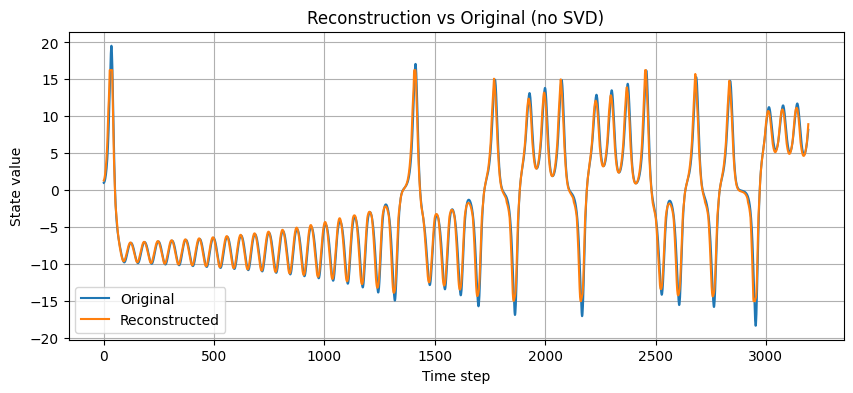

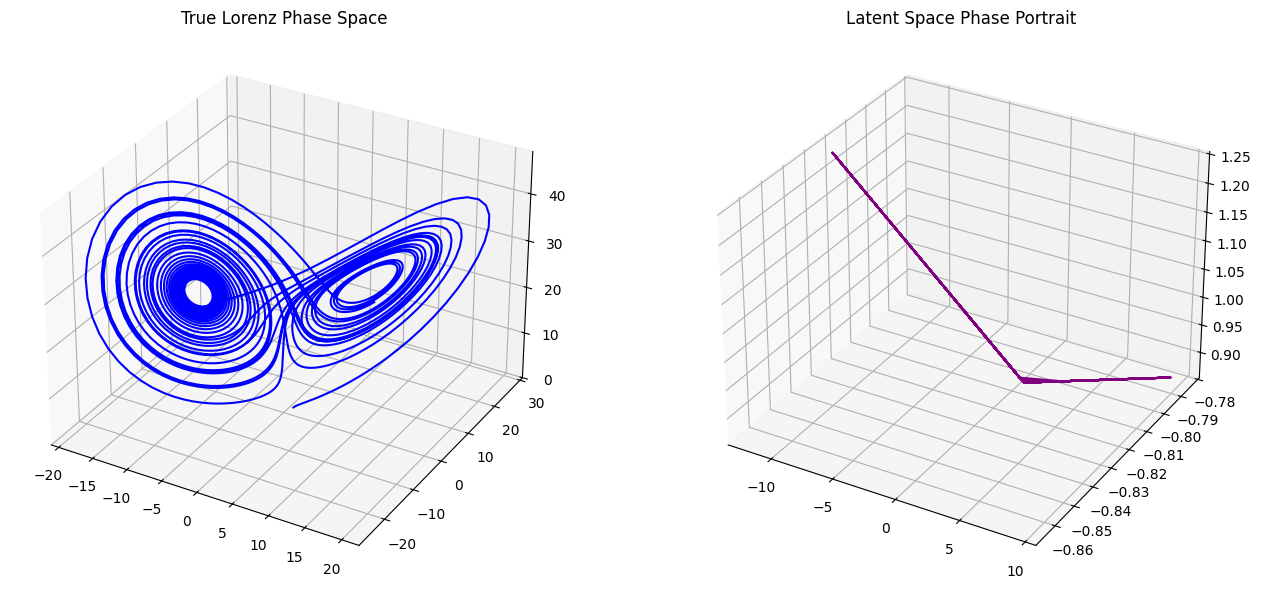

In [5]:
evaluator.evaluate_and_plot()

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_loss_curves(history, norm=False):
    """
    Plots training/validation loss curves for all loss components in history.
    
    Args:
        history (dict): Dictionary with keys like 'train_total', 'val_rec', etc.
        norm (bool): If True, normalize each curve by its initial value.
    """
    assert isinstance(history, dict), "Expected a dict-style history (not a list)."

    # Collect unique loss names (excluding 'train_' and 'val_')
    keys = list(history.keys())
    loss_names = sorted(set(k.split('_', 1)[1] for k in keys))

    n_plots = len(loss_names)
    n_cols = 2
    n_rows = (n_plots + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
    axes = axes.flatten()

    for i, loss in enumerate(loss_names):
        ax = axes[i]
        for prefix in ['train', 'val']:
            key = f"{prefix}_{loss}"
            if key in history:
                values = history[key]
                if norm:
                    values = [v / values[0] for v in values]
                ax.plot(values, label=prefix)

        ax.set_title(f"{loss} loss")
        ax.set_yscale("log")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

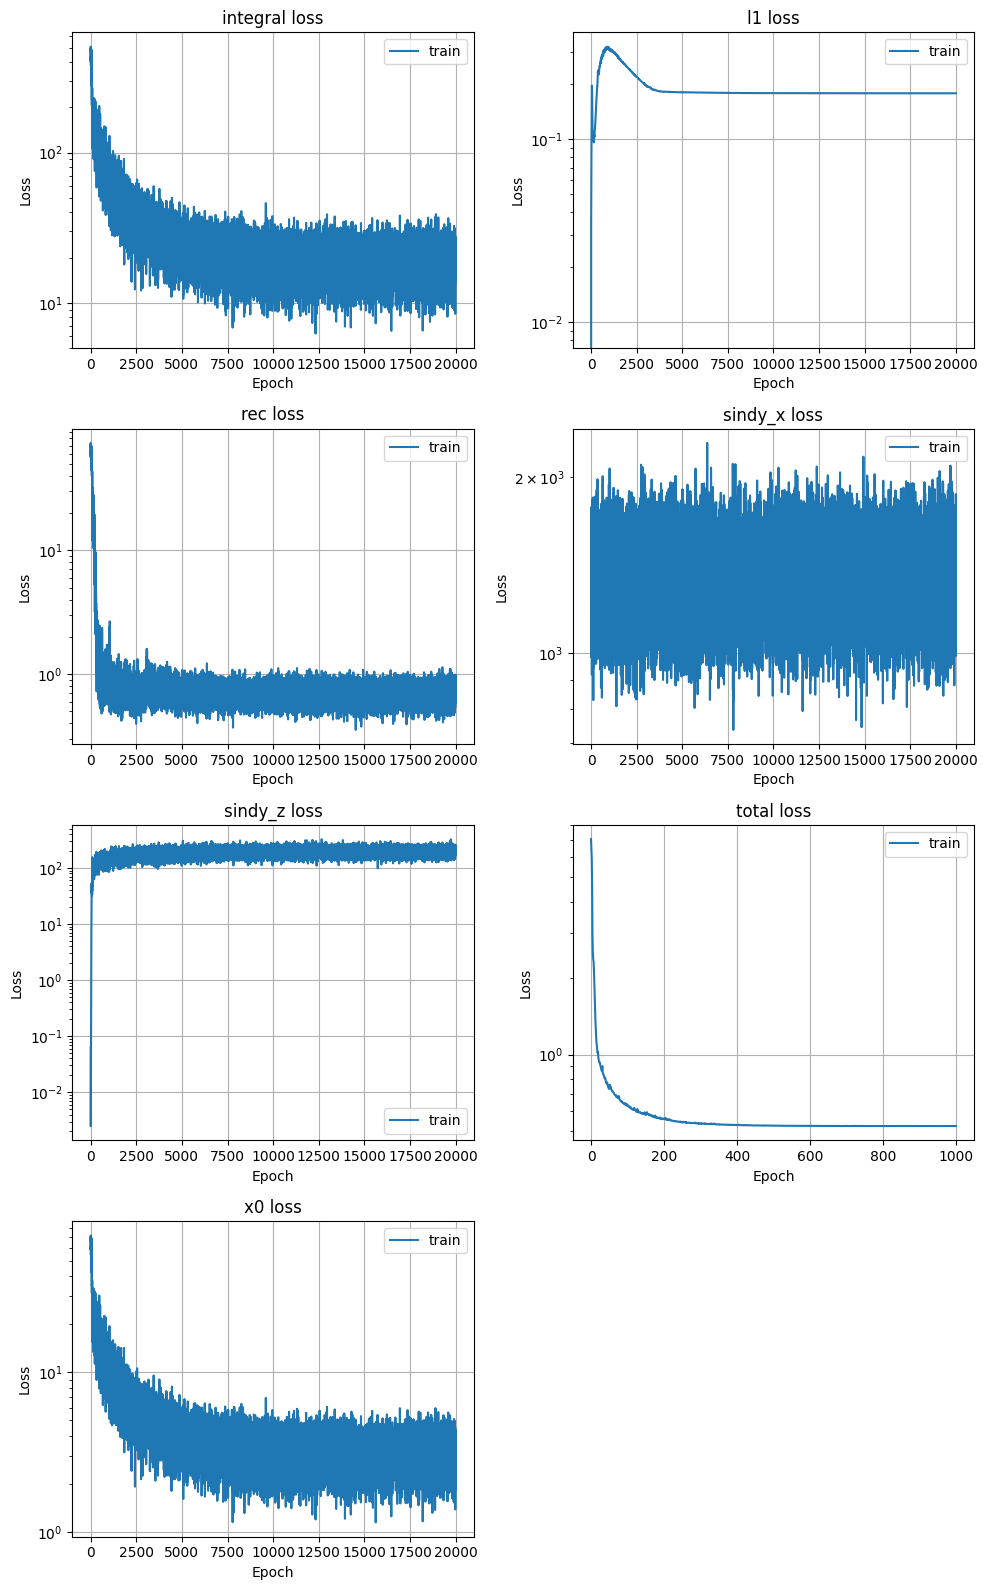

In [7]:
plot_loss_curves(evaluator.trainer.history, norm=False)

In [9]:
from AutoencoderCode.Autoencoder import SindyCall

# === Step 1: Setup Test Environment ===
model = evaluator.trainer.model  # Or wherever your model lives
x_data = evaluator.trainer.data.x
t_data = evaluator.trainer.data.t
threshold = 0.1
update_freq = 1

# === Step 2: Instantiate SindyCall ===
sindy_test = SindyCall(model=model, threshold=threshold, update_freq=update_freq, x=x_data, t=t_data)

# === Step 3: Manually Run SINDy Update ===
try:
    sindy_test.update_sindy(epoch=10)
except Exception as e:
    print("❌ ERROR during SINDy update:", e)

--- Running SINDy ---
[DEBUG] z_latent.shape = (3193, 3)
[DEBUG] dt              = 0.01000
[DEBUG] t.shape = (3193,)
❌ ERROR during SINDy update: If multiple trajectories set, x and if included,x_dot and u, must be Sequences
